In [1]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
from mrcnn.visualize import display_instances
import matplotlib.pyplot as plt
import imgaug

In [ ]:
from mrcnn.config import Config
from mrcnn import model as modellib, utils

In [6]:
import tensorflow as tf
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.model import log
import skimage

In [3]:
pwd

'c:\\Users\\Hashan\\Desktop\\test'

In [9]:
COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

In [10]:
DEFAULT_LOGS_DIR = os.path.join(os.getcwd(), "logs")

In [11]:
DEFAULT_LOGS_DIR

'c:\\Users\\Hashan\\Desktop\\RP021-02\\logs'

In [3]:
class CustomConfig(Config):
    
    NAME = "object"

    GPU_COUNT = 1
    
    IMAGES_PER_GPU = 2
  
    NUM_CLASSES = 1 + 1  

    STEPS_PER_EPOCH = 2

    DETECTION_MIN_CONFIDENCE = 0.9
    
    LEARNING_RATE = 0.001


In [28]:
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        
        self.add_class("object", 1, "disease_detected")

        assert subset in ["train\\images", "val\\images"]
        dataset_dir = os.path.join(dataset_dir, subset)

        
        annotations1 = json.load(open('dataset\\val\\test.json'))
        # print(annotations1)
        annotations = list(annotations1.values())  

        annotations = [a for a in annotations if a['regions']]
        
        for a in annotations:
            
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['names'] for s in a['regions']]
            print("objects:",objects)
            name_dict = {"disease_detected": 1}

            num_ids = [name_dict[a] for a in objects]
     
            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):

        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):

            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

        mask[rr, cc, i] = 1

        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [ ]:
dataset_train = CustomDataset()
dataset_train.load_custom("dataset", "train\\images")
dataset_train.prepare()

objects: ['disease_detected']
numids [1]
objects: ['disease_detected', 'disease_detected', 'disease_detected']
numids [1, 1, 1]
objects: ['disease_detected', 'disease_detected']
numids [1, 1]
objects: ['disease_detected']
numids [1]
objects: ['disease_detected', 'disease_detected', 'disease_detected', 'disease_detected']
numids [1, 1, 1, 1]
objects: ['disease_detected']
numids [1]
objects: ['disease_detected', 'disease_detected']
numids [1, 1]
objects: ['disease_detected']
numids [1]
objects: ['disease_detected']
numids [1]
objects: ['disease_detected', 'disease_detected']
numids [1, 1]
objects: ['disease_detected']
numids [1]
objects: ['disease_detected', 'disease_detected', 'disease_detected', 'disease_detected', 'disease_detected', 'disease_detected', 'disease_detected']
numids [1, 1, 1, 1, 1, 1, 1]
objects: ['disease_detected']
numids [1]
objects: ['disease_detected']
numids [1]
objects: ['disease_detected']
numids [1]
objects: ['disease_detected']
numids [1]
objects: ['disease_det

In [29]:
dataset_val = CustomDataset()
dataset_val.load_custom("dataset", "val\\images")
dataset_val.prepare()

objects: ['disease_detected']
numids [1]
objects: ['disease_detected']
numids [1]
objects: ['disease_detected']
numids [1]
objects: ['disease_detected', 'disease_detected', 'disease_detected', 'disease_detected', 'disease_detected', 'disease_detected']
numids [1, 1, 1, 1, 1, 1]
objects: ['disease_detected']
numids [1]
objects: ['disease_detected']
numids [1]
objects: ['disease_detected', 'disease_detected', 'disease_detected', 'disease_detected', 'disease_detected', 'disease_detected', 'disease_detected']
numids [1, 1, 1, 1, 1, 1, 1]
objects: ['disease_detected']
numids [1]
objects: ['disease_detected']
numids [1]
objects: ['disease_detected', 'disease_detected']
numids [1, 1]
objects: ['disease_detected']
numids [1]
objects: ['disease_detected']
numids [1]
objects: ['disease_detected']
numids [1]
objects: ['disease_detected']
numids [1]
objects: ['disease_detected']
numids [1]
objects: ['disease_detected']
numids [1]
objects: ['disease_detected']
numids [1]
objects: ['disease_detected

In [ ]:
def train(model):
    
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=50,
                layers='heads')
                

In [ ]:
config = CustomConfig()
model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=DEFAULT_LOGS_DIR)

weights_path = COCO_WEIGHTS_PATH
        
if not os.path.exists(weights_path):
  utils.download_trained_weights(weights_path)

model.load_weights(weights_path, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])

train(model)

Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: c:\Users\Hashan\Desktop\test\logs\object20241125T0420\mask_rcnn_object_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDist

c:\Users\Hashan\anaconda3\envs\2mrcnn\lib\site-packages\tensorflow\python\framework\indexed_slices.py:435: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier_1/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_classifier_1/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training/SGD/gradients/gradients/roi_align_classifier_1/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
c:\Users\Hashan\anaconda3\envs\2mrcnn\lib\site-packages\tensorflow\python\framework\indexed_slices.py:435: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier_1/concat_grad/sub_1:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_classi

2/2 [==============================] - ETA: 0s - batch: 0.5000 - size: 2.0000 - loss: 3.1839 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 0.9103 - mrcnn_class_loss: 0.4658 - mrcnn_bbox_loss: 1.1450 - mrcnn_mask_loss: 0.6253      

c:\Users\Hashan\anaconda3\envs\2mrcnn\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


2/2 [==============================] - 484s 388s/step - batch: 0.5000 - size: 2.0000 - loss: 3.1839 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 0.9103 - mrcnn_class_loss: 0.4658 - mrcnn_bbox_loss: 1.1450 - mrcnn_mask_loss: 0.6253 - val_loss: 4.8203 - val_rpn_class_loss: 0.0317 - val_rpn_bbox_loss: 2.3675 - val_mrcnn_class_loss: 0.0537 - val_mrcnn_bbox_loss: 1.4069 - val_mrcnn_mask_loss: 0.9605
Epoch 2/50
2/2 [==============================] - 504s 424s/step - batch: 0.5000 - size: 2.0000 - loss: 4.3153 - rpn_class_loss: 0.0788 - rpn_bbox_loss: 2.2162 - mrcnn_class_loss: 0.1021 - mrcnn_bbox_loss: 1.1305 - mrcnn_mask_loss: 0.7877 - val_loss: 3.5456 - val_rpn_class_loss: 0.0346 - val_rpn_bbox_loss: 1.8418 - val_mrcnn_class_loss: 0.0526 - val_mrcnn_bbox_loss: 0.9658 - val_mrcnn_mask_loss: 0.6507
Epoch 3/50
2/2 [==============================] - 483s 385s/step - batch: 0.5000 - size: 2.0000 - loss: 2.3078 - rpn_class_loss: 0.0387 - rpn_bbox_loss: 0.5548 - mrcnn_class_loss: 0.0793 - mrcnn_bbox

RuntimeError: Can't decrement id ref count (unable to extend file properly)

## testing 

In [12]:
class InferenceConfig(CustomConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    DETECTION_MIN_CONFIDENCE = 0.9


    DETECTION_NMS_THRESHOLD = 0.3

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=DEFAULT_LOGS_DIR)

model_path = 'logs\\object20241125T0420\\mask_rcnn_object_0035.h5'


# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)




Instructions for updating:
Use fn_output_signature instead
Loading weights from  logs\object20241125T0420\mask_rcnn_object_0035.h5
Re-starting from epoch 35


Processing 1 images
image                    shape: (224, 224, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -107.80000  max:  143.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


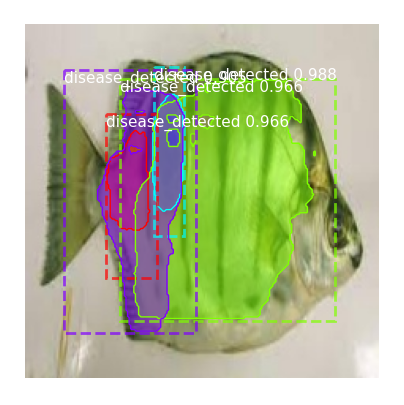

Processing 1 images
image                    shape: (224, 224, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -116.80000  max:  141.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


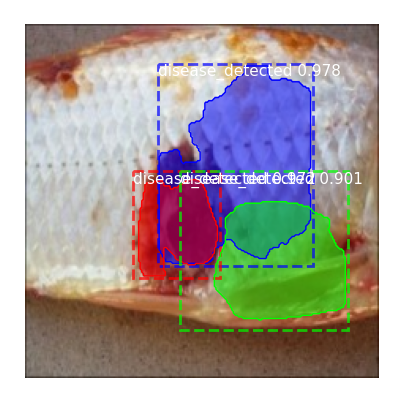

Processing 1 images
image                    shape: (224, 224, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -110.80000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


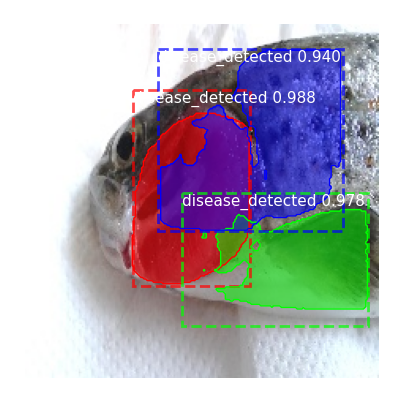

Processing 1 images
image                    shape: (224, 224, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


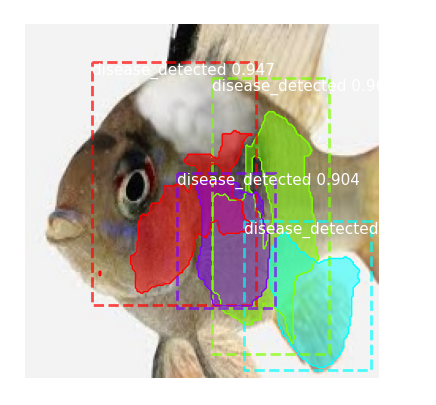

Processing 1 images
image                    shape: (224, 224, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


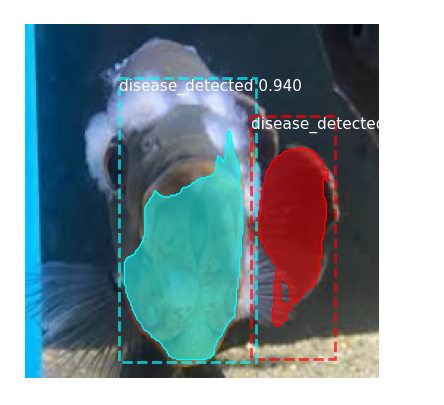

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


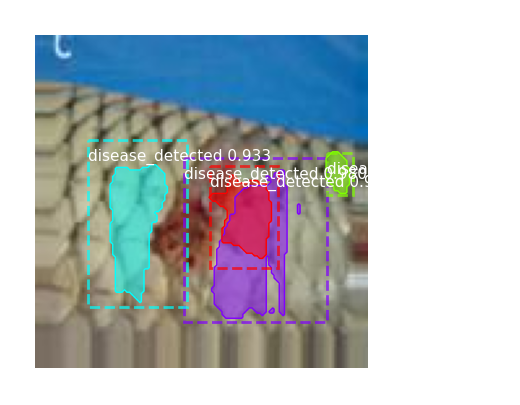

Processing 1 images
image                    shape: (224, 224, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -116.80000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


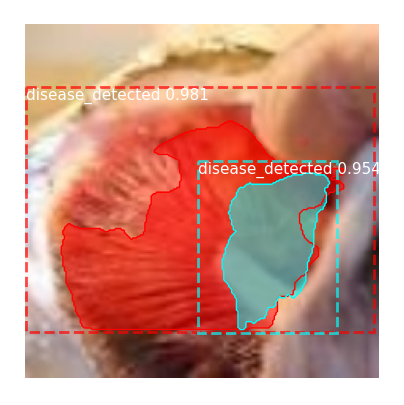

Processing 1 images
image                    shape: (224, 224, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


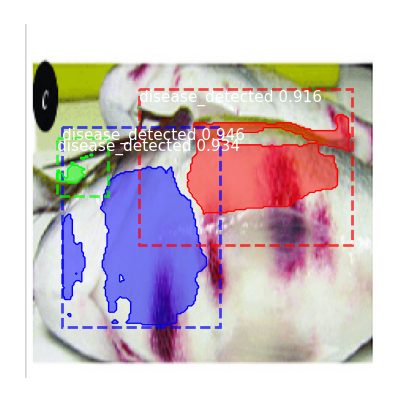

Processing 1 images
image                    shape: (224, 224, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


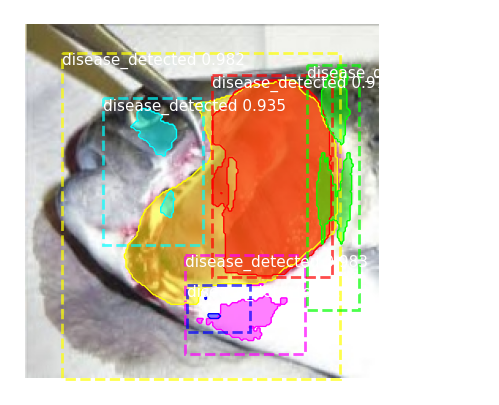

Processing 1 images
image                    shape: (224, 224, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


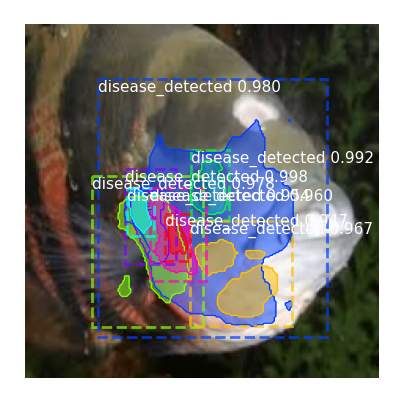

Processing 1 images
image                    shape: (224, 224, 3)         min:    1.00000  max:  240.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -122.70000  max:  135.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


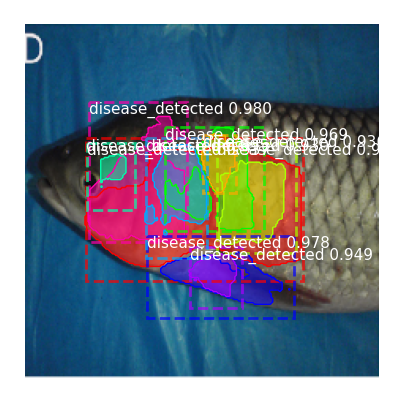

Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


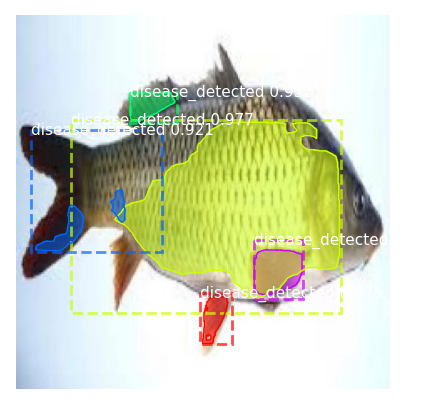

Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  228.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -118.70000  max:  103.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


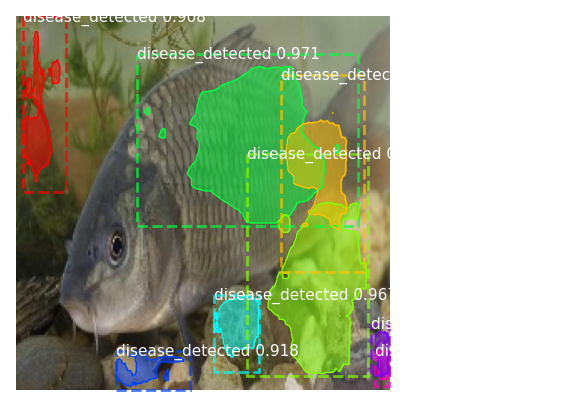

Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  147.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


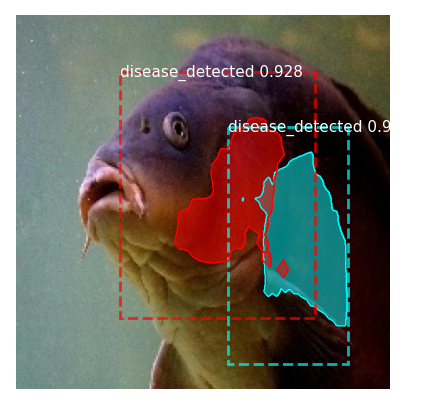

In [30]:
real_test_dir = 'dataset\\test'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))